In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
import sklearn
from scipy.stats import skew
from scipy.stats import pearsonr

In [282]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [283]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [284]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [285]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [286]:
all_data = pd.get_dummies(all_data)

In [287]:
#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [288]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

Ridge Regression finds beta coeff. the minimize:

MSE + lambda * l2norm

and Lasso 

MSE + lambda * l1norm

In [289]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso
from sklearn.model_selection import cross_val_score

In [290]:
model = Ridge(alpha = .1) # alpha is lambda

In [291]:
model

Ridge(alpha=0.1)

In [292]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return (rmse)

In [293]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

In [294]:
print(cv_ridge)

[0.13893637694023933, 0.13777538277187662, 0.13501433618086, 0.13136184989399508, 0.12864892446111806, 0.1278217968925722, 0.12733734668670726, 0.12752940439753785, 0.12895888148450033, 0.1309943785719141, 0.13316366423370232]


Text(0, 0.5, 'rmse')

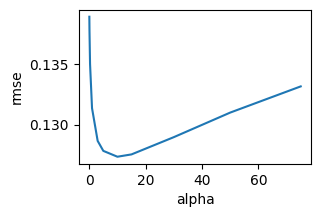

In [295]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha")
plt.ylabel("rmse")

In [296]:
cross_val_score(Ridge(alpha = 5), X_train, y, scoring="neg_mean_squared_error", cv = 5)

array([-0.01243545, -0.0186438 , -0.0163585 , -0.01219677, -0.02332125])

Note: The API will always tries to maximize the score; by using the neg_mean_square_error we get the minimized score instead in effect.

In [297]:
rmse_cv(Ridge(alpha = 5))

array([0.11151436, 0.1365423 , 0.12790036, 0.11043901, 0.15271296])

In [298]:
cv_ridge.min()

0.12733734668670726

In [299]:
# For Part Two, we must make a prediction by running ridge progression with alpha = .1
rmse = rmse_cv(Ridge(alpha = .1)).mean()
rmse

0.13777538277187662

In [300]:
lasso = rmse_cv(LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train, y))
lasso

array([0.10330973, 0.13147319, 0.12552436, 0.10530453, 0.14722499])

In [301]:
ridge_model = RidgeCV(alphas = [.1]).fit(X_train, y)

In [302]:
rmse_cv(ridge_model).mean()

0.13777537506457474

In [303]:
coef = pd.Series(ridge_model.coef_, index = X_train.columns)

In [304]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in the Ridge Model')

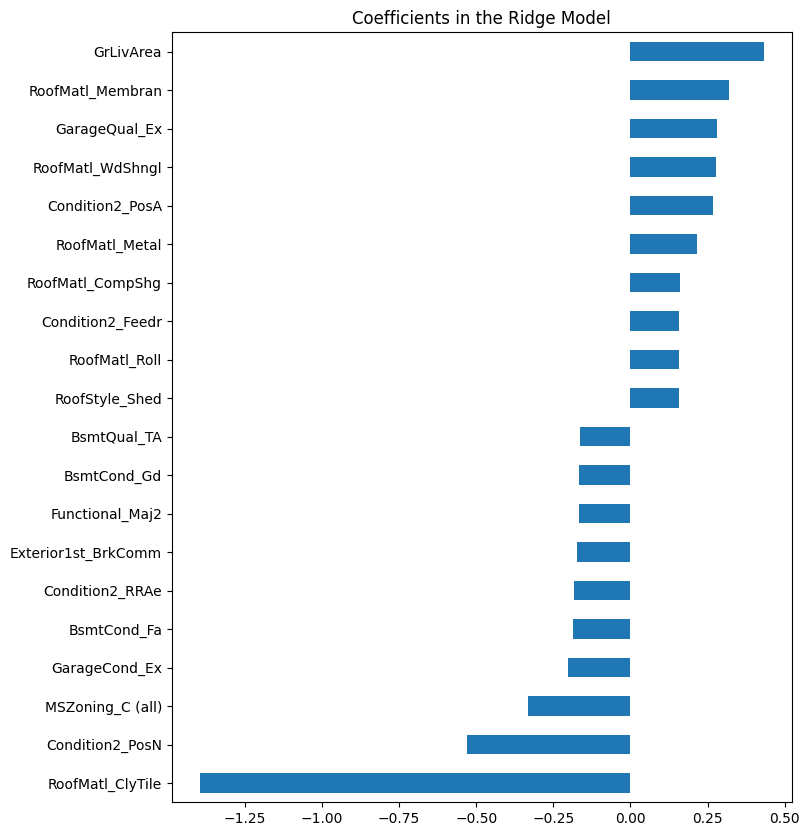

In [305]:
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

In [306]:
ridge_model.predict(X_test)

array([11.70783775, 11.9806699 , 12.14367437, ..., 12.0825758 ,
       11.70858793, 12.29762622])

In [307]:
ridge_predictions = np.expm1(ridge_model.predict(X_test))
ridge_predictions

array([121519.43951695, 159637.93666461, 187900.72577689, ...,
       176763.88661   , 121610.63599745, 219174.09748427])

In [308]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [309]:
results_part2 = pd.DataFrame({'Id' : test['Id'], 'SalePrice' : ridge_predictions})
results_part2.head()

,Id,SalePrice
0,1461,121519.439517
1,1462,159637.936665
2,1463,187900.725777
3,1464,200719.159312
4,1465,199280.925216


In [310]:
# Convert to a CSV file
results_part2.to_csv('Lab2Problem4part2.csv', index = False)

Score: 0.13565

In [311]:
#PART3 Compare Ridge and Regression

In [312]:
alphas = [.1,.2,.3,.4,.5,.6,.7,.8, 1,2,3,4,5,6,7,8,9,10,20,30,50]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

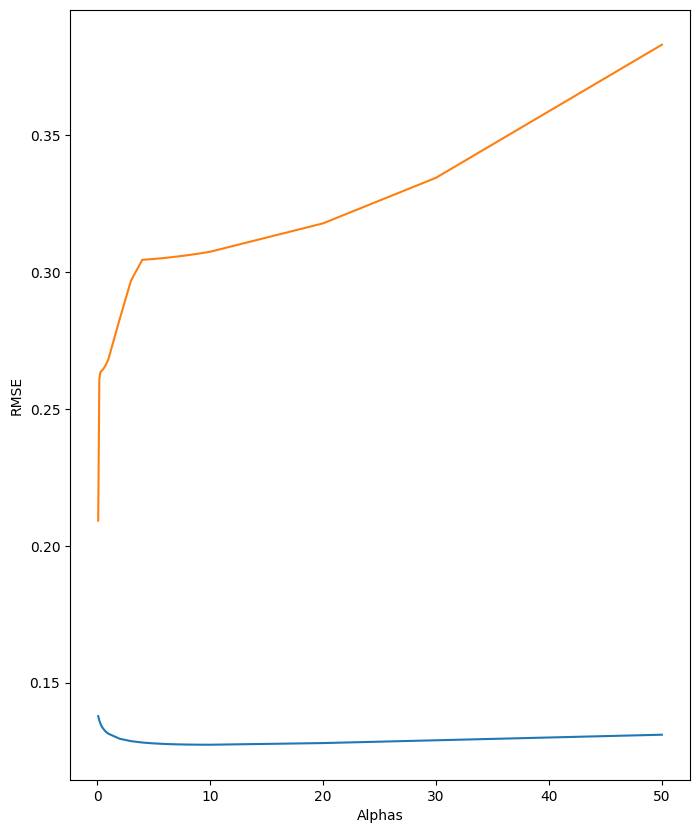

In [313]:
plt.plot(alphas,cv_ridge)
plt.plot(alphas, cv_lasso)
plt.xlabel("Alphas")
plt.ylabel("RMSE")
plt.rcParams['figure.figsize'] = [3, 2]
plt.show()

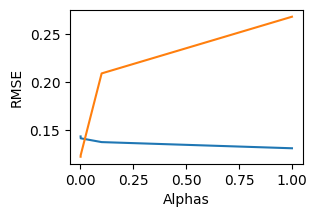

In [314]:
alphas = [1, 0.1, 0.001, 0.0005]
alphas.sort()
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]
plt.plot(alphas,cv_ridge)
plt.plot(alphas, cv_lasso)
plt.xlabel("Alphas")
plt.ylabel("RMSE")
plt.rcParams['figure.figsize'] = [3, 2]
plt.show()

Using the same alpha values, and cross validation, we see that the ridge model is better for non small alphas, while very small alphas favor the Lasso. Furthermore, the Lasso is much more sensitive to increasing alpha.

In [315]:
min_lasso = min(cv_lasso)
min_lasso

0.12256735885048145

In [316]:
min_ridge = min(cv_ridge)
min_ridge

0.13136184989399508

Part 4:

In [317]:
# Compute a Lasso Distribution for various alphas and recorded the l0 norm

In [318]:
l0_norm_counts = []
alphas = [1, 0.1, 0.001, 0.0005]
alphas.sort()
for alpha in alphas:
    model_lasso = LassoCV(alphas = [alpha]).fit(X_train, y)
    count = 0
    # For each beta prediction made by the lasso model
    for coef in model_lasso.coef_:
        #if non zero add
        if coef != 0:
            count += 1
    l0_norm_counts.append(count)


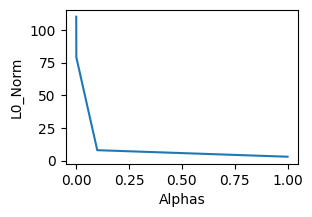

In [319]:
plt.plot(alphas, l0_norm_counts)
plt.xlabel("Alphas")
plt.ylabel("L0_Norm")
plt.rcParams['figure.figsize'] = [3, 2]
plt.show()

We ascertain that as regularization increases, more predictive coeffs are set to zero..

In [320]:
#PART 5

In [321]:
lasso_alpha = .005
ridge_alpha = 10

In [322]:
ridge_model = RidgeCV(alphas = [ridge_alpha]).fit(X_train, y)
lasso_model = LassoCV(alphas = [lasso_alpha]).fit(X_train, y)

In [323]:
ridge_preds = np.expm1(ridge_model.predict(X_test))
lasso_preds = np.expm1(lasso_model.predict(X_test))
X_test.insert(0,"Ridge Predicitons", pd.Series(ridge_preds))
X_test.insert(0,"Lasso Predicitons", pd.Series(lasso_preds))
X_train.insert(0,"Ridge Predicitons", pd.Series(ridge_preds))
X_train.insert(0,"Lasso Predicitons", pd.Series(lasso_preds))
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

In [278]:
X_train.head()

,Lasso Predicitons,Ridge Predicitons,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,134834.271381,119029.138979,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,...,0,0,0,1,0,0,0,0,1,0
1,151426.563288,153034.779102,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,177531.501697,181011.214225,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,...,0,0,0,1,0,0,0,0,1,0
3,205698.593280,197891.150510,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,...,0,0,0,1,1,0,0,0,0,0
4,199775.104278,200308.084966,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,...,0,0,0,1,0,0,0,0,1,0


In [324]:
ridge_stack_model = RidgeCV(alphas = [10]).fit(X_train, y)
print("Stacking and ensembling computes a score of ",rmse_cv(ridge_stack_model).mean())

Stacking and ensembling computes a score of  0.12740064619391747


In [325]:
rsm_preds = ridge_stack_model.predict(X_test)

In [329]:
rsm_df = pd.DataFrame({"Id" : test["Id"] , "SalePrice" : np.expm1(rsm_preds)})
rsm_df.head()

,Id,SalePrice
0,1461,118425.909595
1,1462,152782.401601
2,1463,181082.838824
3,1464,197594.800421
4,1465,200475.473058


In [330]:
rsm_df.to_csv('Lab2P4part5', index = False)

Kaggle gave a score of 0.12487

In [169]:
import xgboost as xgb

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [332]:
#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {"max_depth":2, "eta":0.1}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100)

<AxesSubplot:>

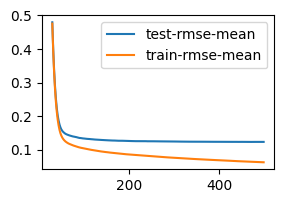

In [333]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [334]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, learning_rate=0.1)

In [335]:
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=360, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [336]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [340]:
xgb_preds = np.expm1(model_xgb.predict(X_test))

In [341]:
xgb_preds

array([120528.96, 156569.97, 186196.9 , ..., 156040.19, 119248.19,
       226422.2 ], dtype=float32)

In [344]:
xgb_df = pd.DataFrame({"Id" : test["Id"] , "SalePrice" : xgb_preds})
xgb_df.to_csv('Lab2P4part6.csv', index = False)

In [345]:
xgb_df.head()

,Id,SalePrice
0,1461,120528.960938
1,1462,156569.968750
2,1463,186196.906250
3,1464,192304.500000
4,1465,185913.000000


Kaggle scored the xgb with 0.13278